# Introduction

In this project, you will build a neural network of your own design to evaluate the CIFAR-10 dataset.

To meet the requirements for this project, you will need to achieve an accuracy greater than 45%. 
If you want to beat Detectocorp's algorithm, you'll need to achieve an accuracy greater than 70%. 
(Beating Detectocorp's algorithm is not a requirement for passing this project, but you're encouraged to try!)

Some of the benchmark results on CIFAR-10 include:

78.9% Accuracy | [Deep Belief Networks; Krizhevsky, 2010](https://www.cs.toronto.edu/~kriz/conv-cifar10-aug2010.pdf)

90.6% Accuracy | [Maxout Networks; Goodfellow et al., 2013](https://arxiv.org/pdf/1302.4389.pdf)

96.0% Accuracy | [Wide Residual Networks; Zagoruyko et al., 2016](https://arxiv.org/pdf/1605.07146.pdf)

99.0% Accuracy | [GPipe; Huang et al., 2018](https://arxiv.org/pdf/1811.06965.pdf)

98.5% Accuracy | [Rethinking Recurrent Neural Networks and other Improvements for ImageClassification; Nguyen et al., 2020](https://arxiv.org/pdf/2007.15161.pdf)

Research with this dataset is ongoing. Notably, many of these networks are quite large and quite expensive to train. 

## Imports

In [26]:
## This cell contains the essential imports you will need – DO NOT CHANGE THE CONTENTS! ##
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import time
print(torch.__version__)
!curl -O https://raw.githubusercontent.com/udacity/workspaces-student-support/master/jupyter/workspace_utils.py


0.4.0
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  1554  100  1554    0     0   6645      0 --:--:-- --:--:-- --:--:--  6815


## Load the Dataset

Specify your transforms as a list first.
The transforms module is already loaded as `transforms`.

CIFAR-10 is fortunately included in the torchvision module.
Then, you can create your dataset using the `CIFAR10` object from `torchvision.datasets` ([the documentation is available here](https://pytorch.org/docs/stable/torchvision/datasets.html#cifar)).
Make sure to specify `download=True`! 

Once your dataset is created, you'll also need to define a `DataLoader` from the `torch.utils.data` module for both the train and the test set.

In [42]:
# Define transforms
## YOUR CODE HERE ##
transform = transforms.Compose([transforms.RandomRotation(30),
                               transforms.RandomHorizontalFlip(),
                               transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))])

# Create training set and define training dataloader
## YOUR CODE HERE ##
batch_size=8 # tried 64, 8 and 4.
trainset = torchvision.datasets.CIFAR10(root='./data', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)

# Create test set and define test dataloader
## YOUR CODE HERE ##
testset = torchvision.datasets.CIFAR10(root='./data', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=True)

# The 10 classes in the dataset
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


## Explore the Dataset
Using matplotlib, numpy, and torch, explore the dimensions of your data.

You can view images using the `show5` function defined below – it takes a data loader as an argument.
Remember that normalized images will look really weird to you! You may want to try changing your transforms to view images.
Typically using no transforms other than `toTensor()` works well for viewing – but not as well for training your network.
If `show5` doesn't work, go back and check your code for creating your data loaders and your training/test sets.

In [43]:
def show5(img_loader):
    dataiter = iter(img_loader)
    
    batch = next(dataiter)
    labels = batch[1][0:5]
    images = batch[0][0:5]
    for i in range(5):
        print(classes[labels[i]])
    
        image = images[i].numpy()
        plt.imshow(np.rot90(image.T, k=3))
        plt.show()

Training set size: 50000
Test set size: 10000
RGB Image Shape[channels,height,width]:[3,32,32]
Exemplar batch and labels


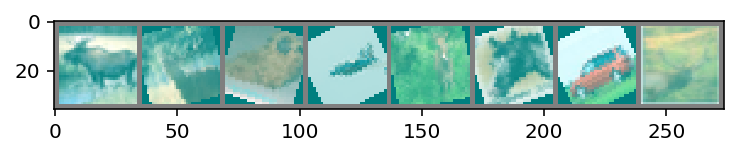

 deer  deer   dog plane  deer horse   car  deer


In [52]:
# Explore data
## YOUR CODE HERE ##
# inspired from https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images (in this case the first batch)
dataiter = iter(trainloader)
images, labels = dataiter.next()


# datasize and input image shape
print("Training set size:",len(trainset.train_labels))
print("Test set size:",len(testset.test_labels))
shape=images[0].shape
print("RGB Image Shape[channels,height,width]:[{},{},{}]".format(shape[0],shape[1],shape[2]))

# show images
print("Exemplar batch and labels")
imshow(torchvision.utils.make_grid(images))

# print labels according to the grid
grid_sizes=batch_size
if batch_size>8:
    grid_sizes=int(np.sqrt(batch_size))
pos=range(0, batch_size, grid_sizes)


for i in pos:
    print(' '.join('%5s' % classes[labels[j]] for j in range(i,i+grid_sizes)))

## Build your Neural Network
Using the layers in `torch.nn` (which has been imported as `nn`) and the `torch.nn.functional` module (imported as `F`), construct a neural network based on the parameters of the dataset. 
Feel free to construct a model of any architecture – feedforward, convolutional, or even something more advanced!

In [57]:
## YOUR CODE HERE ##
import torch.nn as nn
import torch.nn.functional as F

# the network is inspired on https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html,
# and dropout layers were added to each layear, to better regularised this implementation.


class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        # Dropout module with 0.2 drop probability
        self.dropout = nn.Dropout(p=0.2)
    
    def forward(self, x):
        x = self.pool(self.dropout(F.relu(self.conv1(x))))
        x = self.pool(self.dropout(F.relu(self.conv2(x))))
        x = x.view(x.shape[0], -1)
        #x = nn.flatten(x, 1) # flatten all dimensions except batch
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.fc3(x)
        
        
        return x


net = Classifier()


Specify a loss function and an optimizer, and instantiate the model.

If you use a less common loss function, please note why you chose that loss function in a comment.

In [58]:
## YOUR CODE HERE ##
import torch.optim as optim
#nn.CrossEntropyLoss: the combination of nn.LogSoftmax and nn.NLLLoss.
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9, weight_decay=5e-4) # experimented also with default decay

## Running your Neural Network
Use whatever method you like to train your neural network, and ensure you record the average loss at each epoch. 
Don't forget to use `torch.device()` and the `.to()` method for both your model and your data if you are using GPU!

If you want to print your loss during each epoch, you can use the `enumerate` function and print the loss after a set number of batches. 250 batches works well for most people!

In [60]:
## YOUR CODE HERE ##
from workspace_utils import active_session
with active_session():
    # move into a cuda-enabled device
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    # # Assuming that we are on a CUDA machine, this should print a CUDA device:
    print(device)
    net.to(device)

    epochs = 60

    train_losses, test_losses = [], []
    train_accs, test_accs = [], []
    epoch_list = range(epochs)

    for e in epoch_list:

        tot_train_loss = 0
        train_correct = 0
        running_loss = 0.0

        for i, data in enumerate(trainloader, 0):

            images, labels = data[0].to(device), data[1].to(device)
            #images, labels = data

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            log_ps = net(images)
            loss = criterion(log_ps, labels)
            loss.backward()
            optimizer.step()

            tot_train_loss += loss.item()

            # compute train data accuracy
            ps = torch.exp(log_ps)
            top_p, top_class = ps.topk(1, dim=1)
            equals = top_class == labels.view(*top_class.shape)
            train_correct += equals.sum().item()

        else:
            tot_test_loss = 0
            test_correct = 0  # Number of correct predictions on the test set

            # Turn off gradients for validation, saves memory and computations
            with torch.no_grad():
                for images, labels in testloader:
                    images, labels = images.to(device), labels.to(device)

                    log_ps = net(images)
                    loss = criterion(log_ps, labels)
                    tot_test_loss += loss.item()

                    ps = torch.exp(log_ps)
                    top_p, top_class = ps.topk(1, dim=1)
                    equals = top_class == labels.view(*top_class.shape)
                    test_correct += equals.sum().item()

            # Get mean loss to enable comparison between train and test sets
            train_loss = tot_train_loss / len(trainloader.dataset)
            test_loss = tot_test_loss / len(testloader.dataset)

            # At completion of epoch
            train_losses.append(train_loss)
            test_losses.append(test_loss)
            train_accs.append(train_correct / len(trainloader.dataset))
            test_accs.append(test_correct / len(testloader.dataset))

            print("Epoch: {}/{}.. ".format(e+1, epochs),
                  "Training Loss: {:.3f}.. ".format(train_loss),
                  "Test Loss: {:.3f}.. ".format(test_loss),
                  "Train Accuracy: {:.3f}".format(train_correct / len(trainloader.dataset)),
                  "Test Accuracy: {:.3f}".format(test_correct / len(testloader.dataset)))

    PATH = './cifar_small_net.pth'
    torch.save(net.state_dict(), PATH)


cuda:0
Epoch: 1/60..  Training Loss: 0.156..  Test Loss: 0.157..  Train Accuracy: 0.562 Test Accuracy: 0.556
Epoch: 2/60..  Training Loss: 0.155..  Test Loss: 0.157..  Train Accuracy: 0.561 Test Accuracy: 0.552
Epoch: 3/60..  Training Loss: 0.154..  Test Loss: 0.156..  Train Accuracy: 0.566 Test Accuracy: 0.557
Epoch: 4/60..  Training Loss: 0.153..  Test Loss: 0.156..  Train Accuracy: 0.569 Test Accuracy: 0.560
Epoch: 5/60..  Training Loss: 0.153..  Test Loss: 0.157..  Train Accuracy: 0.570 Test Accuracy: 0.556
Epoch: 6/60..  Training Loss: 0.153..  Test Loss: 0.159..  Train Accuracy: 0.571 Test Accuracy: 0.561
Epoch: 7/60..  Training Loss: 0.152..  Test Loss: 0.154..  Train Accuracy: 0.575 Test Accuracy: 0.565
Epoch: 8/60..  Training Loss: 0.151..  Test Loss: 0.156..  Train Accuracy: 0.573 Test Accuracy: 0.555
Epoch: 9/60..  Training Loss: 0.150..  Test Loss: 0.158..  Train Accuracy: 0.581 Test Accuracy: 0.554
Epoch: 10/60..  Training Loss: 0.150..  Test Loss: 0.157..  Train Accuracy:

Plot the training loss (and validation loss/accuracy, if recorded).

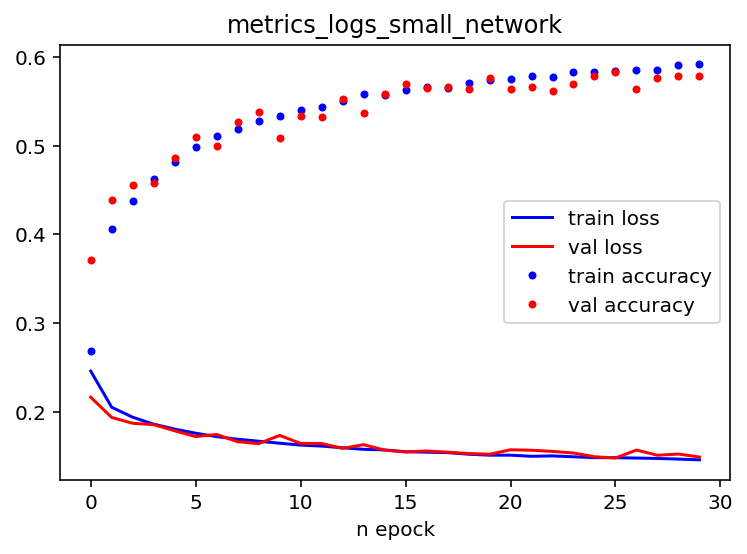

In [56]:
## YOUR CODE HERE ##

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt

def draw_metric_logs(lst_iter, train_loss, train_acc, test_loss, test_acc, title):
    plt.plot(lst_iter, train_loss, '-b', label='train loss')
    plt.plot(lst_iter, test_loss, '-r', label='val loss')
    plt.plot(lst_iter, train_acc, '.b', label='train accuracy')
    plt.plot(lst_iter, test_acc, '.r', label='val accuracy')

    plt.xlabel("n epock")
    plt.legend(loc='best')
    plt.title(title)

    # save image
    plt.savefig(title+".png")  # should before show method
    
    # show
    plt.show()
    
title = 'metrics_logs_small_network'    
    
draw_metric_logs(epoch_list, train_losses, train_accs, test_losses, test_accs, title)

In [3]:
# various references were studied to achieve this code:
# # https://github.com/weiaicunzai/pytorch-cifar100/blob/master/train.py
# https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html
# https://github.com/udacity/deep-learning-v2-pytorch/blob/master/intro-to-pytorch/Part%208%20-%20Transfer%20Learning%20(Solution).ipynb
# udacities classes

from workspace_utils import active_session
with active_session():



    # TODO: Define transforms for the training data and testing data
    train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                           transforms.RandomResizedCrop(224),
                                           transforms.RandomHorizontalFlip(),
                                           transforms.ToTensor(),
                                           transforms.Normalize([0.485, 0.456, 0.406],
                                                                [0.229, 0.224, 0.225])])

    test_transforms = transforms.Compose([transforms.Resize(255),
                                          transforms.CenterCrop(224),
                                          transforms.ToTensor(),
                                          transforms.Normalize([0.485, 0.456, 0.406],
                                                               [0.229, 0.224, 0.225])])

    # Pass transforms in here, then run the next cell to see how the transforms look
    batch_size=16
    trainset = torchvision.datasets.CIFAR10(root='./data', download=True, train=True, transform=train_transforms)
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)

    # Create test set and define test dataloader
    ## YOUR CODE HERE ##
    testset = torchvision.datasets.CIFAR10(root='./data', download=True, train=False, transform=test_transforms)
    testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=True)

    #Freeze parameters so we don't backprop through them
    model = torchvision.models.densenet121(pretrained=True)
    model

    for param in model.parameters():
        param.requires_grad = False

    from collections import OrderedDict
    classifier = nn.Sequential(OrderedDict([
                              ('fc1', nn.Linear(1024, 500)),
                              ('relu', nn.ReLU()),
                              ('fc2', nn.Linear(500, 10))
                              ]))

    model.classifier =  classifier
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    #The combination of nn.LogSoftmax and nn.NLLLoss is equivalent to using nn.CrossEntropyLoss.
    criterion2 = nn.CrossEntropyLoss()
    optimizer2 = optim.SGD(model.classifier.parameters(), lr=0.001, momentum=0.9, weight_decay=5e-4)
    model.to(device);

    start = time.time()
    # move into a cuda-enabled device
    # device = torch.device("cpu" if torch.cuda.is_available() else "cpu")
    # # Assuming that we are on a CUDA machine, this should print a CUDA device:
    # print(device)
    # net.to(device)

    epochs = 30

    train_losses, test_losses = [], []
    train_accs, test_accs = [], []
    epoch_list = range(epochs)
    EPOCH_MILESTONE = 6;
    best_acc=0;

    for e in epoch_list:

        tot_train_loss = 0
        train_correct = 0
        running_loss = 0.0
        start_epoch = time.time()

        for i, data in enumerate(trainloader, 0):

            #images, labels = images.to(device), labels.to(device)
            images, labels = data[0].to(device),data[1].to(device)

            # zero the parameter gradients
            optimizer2.zero_grad()

            # forward + backward + optimize
            log_ps = model.forward(images)
            loss = criterion2(log_ps, labels)
            loss.backward()
            optimizer2.step()

            tot_train_loss += loss.item()

            # compute train data accuracy
            ps = torch.exp(log_ps)
            top_p, top_class = ps.topk(1, dim=1)
            equals = top_class == labels.view(*top_class.shape)
            train_correct += equals.sum().item()

        else:
            tot_test_loss = 0
            test_correct = 0  # Number of correct predictions on the test set

            # Turn off gradients for validation, saves memory and computations
            with torch.no_grad():
                for images, labels in testloader:

                    images, labels = images.to(device), labels.to(device)

                    log_ps = model.forward(images)
                    loss = criterion2(log_ps, labels)
                    tot_test_loss += loss.item()

                    ps = torch.exp(log_ps)
                    top_p, top_class = ps.topk(1, dim=1)
                    equals = top_class == labels.view(*top_class.shape)
                    test_correct += equals.sum().item()

            # Get mean loss to enable comparison between train and test sets
            train_loss = tot_train_loss / len(trainloader.dataset)
            test_loss = tot_test_loss / len(testloader.dataset)

            # At completion of epoch
            train_losses.append(train_loss)
            test_losses.append(test_loss)
            train_accs.append(train_correct / len(trainloader.dataset))
            acc=test_correct / len(testloader.dataset)
            test_accs.append(acc)

            print("Epoch: {}/{}.. ".format(e+1, epochs),
                  "Training Loss: {:.3f}.. ".format(train_loss),
                  "Test Loss: {:.3f}.. ".format(test_loss),
                  "Train Accuracy: {:.3f}".format(train_correct / len(trainloader.dataset)),
                  "Test Accuracy: {:.3f}".format(test_correct / len(testloader.dataset)))

            if e > EPOCH_MILESTONE and best_acc < acc:
                PATH = "./cifar10_densenet_"+str(e)+"_best"
                print('saving weights file to {}'.format(PATH))
                torch.save(model.state_dict(), PATH)
                best_acc = acc
                continue

            if not e % EPOCH_MILESTONE:
                PATH = "./cifar10_densenet_"+str(e)+"_regular"
                print('saving weights file to {}'.format(PATH))
                torch.save(model.state_dict(), PATH)

            finish_epoch = time.time()
            print('epoch {} training time consumed: {:.2f}s'.format(e, finish_epoch - start_epoch))


    finish = time.time()

    print('epoch {} training time consumed: {:.2f}s'.format(e, finish - start))

    PATH = './cifar10_densenet_final.pth'
    torch.save(model.state_dict(), PATH)

    # draw acc and loss for pre-trained network    
    title = 'metrics_logs_pre-trained_network'    

    draw_metric_logs(epoch_list, train_losses, train_accs, test_losses, test_accs, title)

Files already downloaded and verified
Files already downloaded and verified


/opt/conda/lib/python3.6/site-packages/torchvision-0.2.1-py3.6.egg/torchvision/models/densenet.py:212: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.torch/models/densenet121-a639ec97.pth
100%|██████████| 32342954/32342954 [00:00<00:00, 82694795.64it/s]


Epoch: 1/30..  Training Loss: 0.102..  Test Loss: 0.063..  Train Accuracy: 0.419 Test Accuracy: 0.667
saving weights file to ./cifar10_densenet_0_regular
epoch 0 training time consumed: 606.01s
Epoch: 2/30..  Training Loss: 0.091..  Test Loss: 0.061..  Train Accuracy: 0.479 Test Accuracy: 0.674
epoch 1 training time consumed: 570.33s
Epoch: 3/30..  Training Loss: 0.089..  Test Loss: 0.058..  Train Accuracy: 0.491 Test Accuracy: 0.691
epoch 2 training time consumed: 573.40s
Epoch: 4/30..  Training Loss: 0.088..  Test Loss: 0.057..  Train Accuracy: 0.499 Test Accuracy: 0.694
epoch 3 training time consumed: 569.30s
Epoch: 5/30..  Training Loss: 0.087..  Test Loss: 0.056..  Train Accuracy: 0.505 Test Accuracy: 0.697
epoch 4 training time consumed: 572.94s
Epoch: 6/30..  Training Loss: 0.086..  Test Loss: 0.057..  Train Accuracy: 0.507 Test Accuracy: 0.685
epoch 5 training time consumed: 569.37s
Epoch: 7/30..  Training Loss: 0.085..  Test Loss: 0.055..  Train Accuracy: 0.512 Test Accuracy: 

NameError: name 'epoch' is not defined

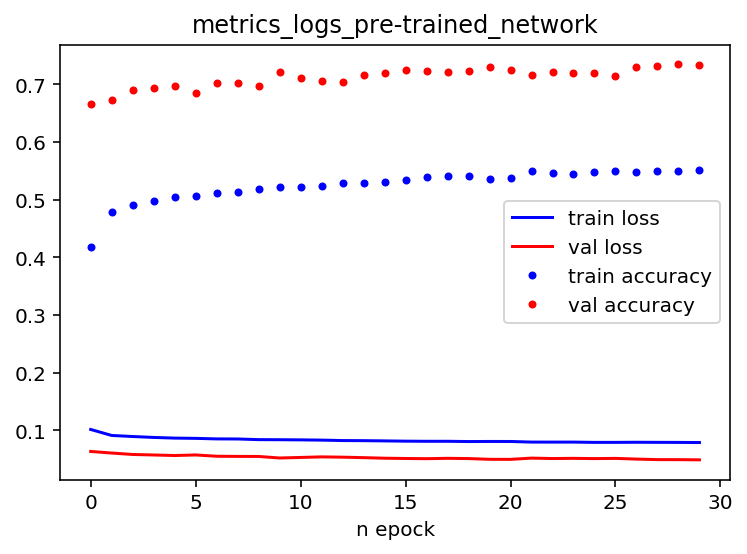

In [10]:
PATH = './cifar10_densenet_final.pth'
torch.save(model.state_dict(), PATH)

# draw acc and loss for pre-trained network    
title = 'metrics_logs_pre-trained_network'    
draw_metric_logs(epoch_list, train_losses, train_accs, test_losses, test_accs, title)

## Testing your model
Using the previously created `DataLoader` for the test set, compute the percentage of correct predictions using the highest probability prediction. 

If your accuracy is over 70%, great work! 
This is a hard task to exceed 70% on.

If your accuracy is under 45%, you'll need to make improvements.
Go back and check your model architecture, loss function, and optimizer to make sure they're appropriate for an image classification task.

In [61]:
## YOUR CODE HERE ##
## Testing small-network ##
PATH = './cifar_small_net.pth'
net = Classifier()
net.load_state_dict(torch.load(PATH))

transform = transforms.Compose([transforms.RandomRotation(30),
                               transforms.RandomHorizontalFlip(),
                               transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))])

batch_size=8 # tried 64, 8 and 4.
# Create test set and define test dataloader
testset = torchvision.datasets.CIFAR10(root='./data', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=True)

correct = 0
total = 0

with torch.no_grad():
    
    for images, labels in testloader:
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
    
        total += labels.size(0)

        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Files already downloaded and verified
Accuracy of the network on the 10000 test images: 59 %


In [23]:
## Testing pre-trained model ##
test_transforms = transforms.Compose([transforms.Resize(255),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])

batch_size=16

testset = torchvision.datasets.CIFAR10(root='./data', download=True, train=False, transform=test_transforms)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=True)

correct = 0
total = 0

with torch.no_grad():
    
    for images, labels in testloader:
        images, labels = images.to(device), labels.to(device)
        # calculate outputs by running images through the network
        outputs = model.forward(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
    
        total += labels.size(0)

        correct += (predicted == labels).sum().item()

print('Accuracy of the pre-trained-densenet network on the 10000 test images: %d %%' % (
    100 * correct / total))

Files already downloaded and verified
Accuracy of the pre-trained-densenet network on the 10000 test images: 73 %


## Saving your model
Using `torch.save`, save your model for future loading.

In [24]:
## YOUR CODE HERE ##
# Saving the small model here again to complete the project.
PATH = './cifar_small_net_final.pth'
torch.save(net.state_dict(), PATH)

## Make a Recommendation

Based on your evaluation, what is your recommendation on whether to build or buy? Explain your reasoning below.

Some things to consider as you formulate your recommendation:
* How does your model compare to Detectocorp's model?
* How does it compare to the far more advanced solutions in the literature? 
* What did you do to get the accuracy you achieved? 
* Is it necessary to improve this accuracy? If so, what sort of work would be involved in improving it?

## Answer

In this project I followed 2 strategies to build the CIFAR-10 image classifier model:

A) trained a small neural network classifier;

B) used a pre-trained densenet model, and retrained the classification layer to tune it to these training data.

### How does your model compare to Detectocorp's model?

While the first model performed worst than Detectocorps (59% vs 70% accuracy), the second model showed a superior accuracy, 73%. 

### How does it compare to the far more advanced solutions in the literature?

The performance of both methodologies was lower than any of the advanced solutions.

### What did you do to get the accuracy you achieved?

For the small-network the following parameters were tried:
- different batch sizes: 4, 8, and 64.
- different optimisers: Adam vs SGD
- different SGD parameters: default weight decay and 5e-4, lr of 0.003 and 0.001
- addition of dropout layers
- different transforms (one with and one without data augmentation).

Before trying more parameter tunning I decided to compare the previous with a pre-trained network approach. Using a pre-trained densenet boosted the performance on the test data by 14%.

### Is it necessary to improve this accuracy? If so, what sort of work would be involved in improving it?

Although it took much more time to train the pre-trained network, and the use of the udacity-workspace GPU, I believe the next steps should be doing hyper-parameter tunning (using random-search or grid-search), on a classifier layer added on pre-trained networks. I.e. (if the budget allowed it), I would improve this work first on the available open-source image-classification models (e.g. resnet, inception, VGG), selecting that rendering the best performance.

Finally, after the hyper-parameter tuning, if the results are still lower than the literature models, I would indeed purchase them, as a good image classification is required to make sure the correct decisions can be taken in the self-driving car software.

Additionally, these networks could also be re-used as pre-trained networks and further retrained on Detectocorp's datasets, to improve the detection of objects vital to the company's product.


## Submit Your Project

When you are finished editing the notebook and are ready to turn it in, simply click the **SUBMIT PROJECT** button in the lower right.

Once you submit your project, we'll review your work and give you feedback if there's anything that you need to work on. If you'd like to see the exact points that your reviewer will check for when looking at your work, you can have a look over the project [rubric](https://review.udacity.com/#!/rubrics/3077/view).